In [27]:
# Importing Libraries
import numpy as np
import librosa
import scipy
from scipy import signal
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt
import os

In [28]:
# Path to the folder containing audio recordings
folder_path = 'recordings'
cutoff_freq = 5000  # Specify cutoff frequency for lowpass filter

### Function for Low-Pass Filer

In [29]:
# Function to apply lowpass filter to audio signal
def apply_lowpass_filter(signal, cutoff_freq, sr):
    b, a = scipy.signal.butter(4, cutoff_freq / (sr / 2), 'low')
    filtered_signal = scipy.signal.lfilter(b, a, signal)
    return filtered_signal

### Function to Extract Ceptrum Coefficients

In [44]:
# Function to extract cepstrum features
def extract_cepstrum_features(audio_file, cutoff_freq):
    signal, sr = librosa.load(audio_file)

    # Applying Low-Pass Filter
    filtered_signal = apply_lowpass_filter(signal, cutoff_freq, sr)  # Apply lowpass filter
    stft = np.abs(librosa.stft(filtered_signal))
    cepstrum = librosa.feature.mfcc(S=librosa.amplitude_to_db(stft), n_mfcc=13)
    return cepstrum.T

### Data Preprocessing

In [31]:
# List to store cepstrum features and corresponding labels
features_list = []
labels_list = []

In [32]:
# Iterate over audio files in the folder
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    # Extract cepstrum features
    features = extract_cepstrum_features(file_path, cutoff_freq)
    # Add features to the list
    features_list.append(features)
    # Add label (file name without extension) to the list
    label = os.path.splitext(file_name)[0]
    labels_list.append(label)

In [33]:
# Convert lists to numpy arrays
features_array = np.concatenate(features_list)
labels_array = np.array(labels_list)

In [34]:
# Perform K-means clustering
k = 5  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(features_array)

# Generate labels based on the clusters
labels = clusters

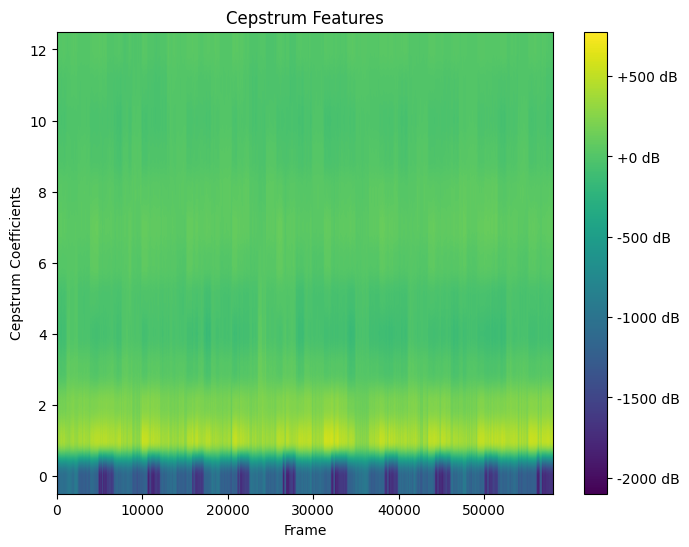

In [35]:
# Display cepstrum features
plt.figure(figsize=(8, 6))
plt.imshow(features_array.T, cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(format='%+2.0f dB')
plt.title('Cepstrum Features')
plt.xlabel('Frame')
plt.ylabel('Cepstrum Coefficients')
plt.show()

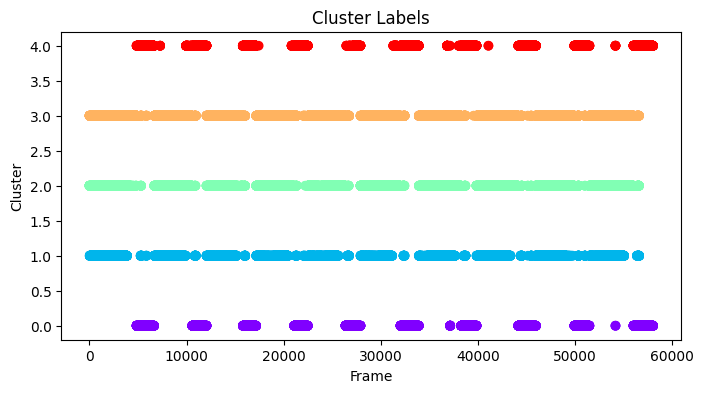

In [36]:
# Display cluster labels
plt.figure(figsize=(8, 4))
plt.scatter(range(len(labels)), labels, c=labels, cmap='rainbow')
plt.title('Cluster Labels')
plt.xlabel('Frame')
plt.ylabel('Cluster')
plt.show()

### Training ANN Neural Network

In [37]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_array, labels, test_size=0.2, random_state=42
)

# Build the Neural Network Model
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(features_array.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(k, activation='softmax')  # Output layer size matches the number of clusters
])

In [39]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
1451/1451 [==============================] - 7s 4ms/step - loss: 2.2988 - accuracy: 0.6811 - val_loss: 1.0926 - val_accuracy: 0.7144
Epoch 2/10
1451/1451 [==============================] - 5s 4ms/step - loss: 0.9910 - accuracy: 0.7408 - val_loss: 0.7758 - val_accuracy: 0.7503
Epoch 3/10
1451/1451 [==============================] - 6s 4ms/step - loss: 0.7681 - accuracy: 0.7655 - val_loss: 0.5906 - val_accuracy: 0.7906
Epoch 4/10
1451/1451 [==============================] - 5s 3ms/step - loss: 0.6341 - accuracy: 0.7842 - val_loss: 0.4233 - val_accuracy: 0.8343
Epoch 5/10
1451/1451 [==============================] - 5s 4ms/step - loss: 0.5003 - accuracy: 0.8089 - val_loss: 0.3912 - val_accuracy: 0.8436
Epoch 6/10
1451/1451 [==============================] - 6s 4ms/step - loss: 0.4325 - accuracy: 0.8284 - val_loss: 0.5022 - val_accuracy: 0.7857
Epoch 7/10
1451/1451 [==============================] - 5s 3ms/step - loss: 0.3869 - accuracy: 0.8442 - val_loss: 0.3403 - val_accuracy:

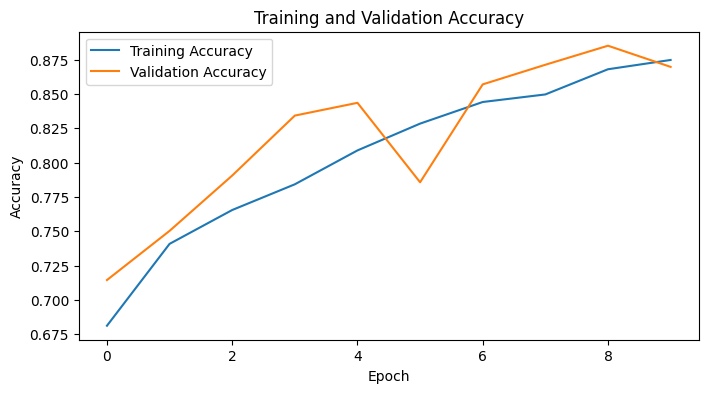

In [40]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

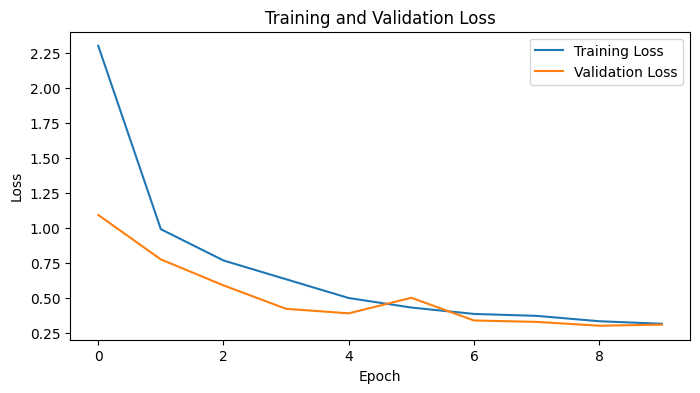

In [41]:
# Plot training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluating Our Model

In [42]:
#Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

#Make predictions on the test data
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

363/363 [==============================] - 1s 3ms/step - loss: 0.3107 - accuracy: 0.8697
Test Loss: 0.3106944262981415
Test Accuracy: 0.8697450160980225
363/363 [==============================] - 1s 2ms/step


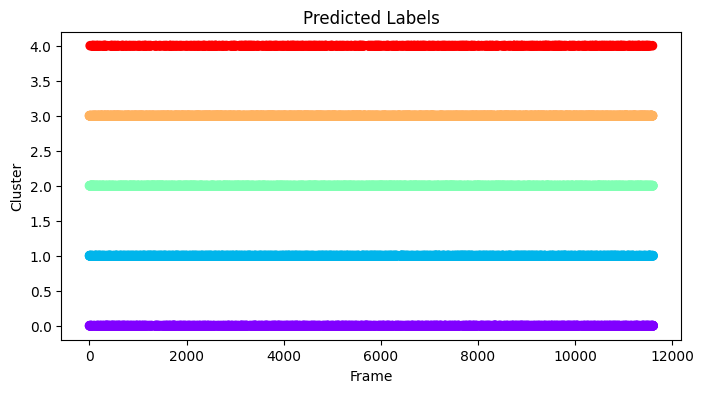

In [43]:
plt.figure(figsize=(8, 4))
plt.scatter(range(len(predicted_labels)), predicted_labels, c=predicted_labels, cmap='rainbow')
plt.title('Predicted Labels')
plt.xlabel('Frame')
plt.ylabel('Cluster')
plt.show()